Data Set Information:

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:

1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.globalactivepower: household global minute-averaged active power (in kilowatt)

4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from time import time
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt',sep=';',parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'],index_col='dt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.shape


(2075259, 7)

In [ ]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

From the code below, we can see null values in the dataset. We are handling null values by carrying out mean imputation.

In [ ]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
for col in list(df.columns):
  df[col].fillna(df[col].mean(),inplace=True)

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Exploratory Data Analysis of the Dataset

From the data analysis we can see global active power peaks during winter and drops to the bottom during summer.

Text(0.5, 1.0, 'Global Active Power mean for each day vs time')

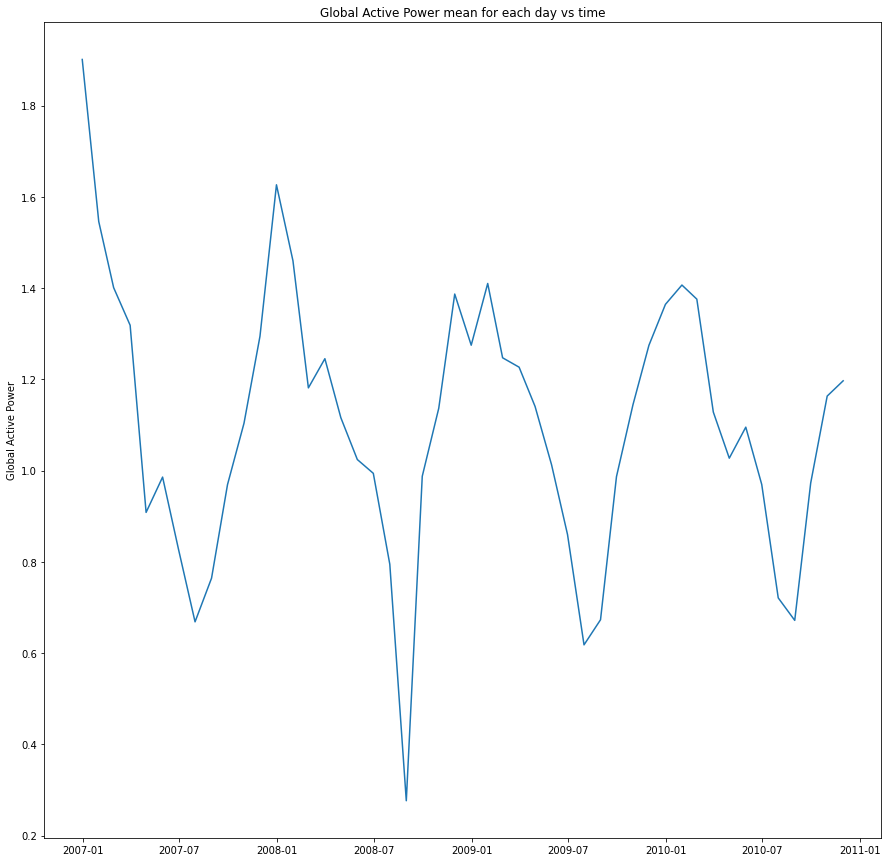

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.plot(df['Global_active_power'].resample('M').mean())
plt.ylabel('Global Active Power')
plt.title('Global Active Power mean for each day vs time')

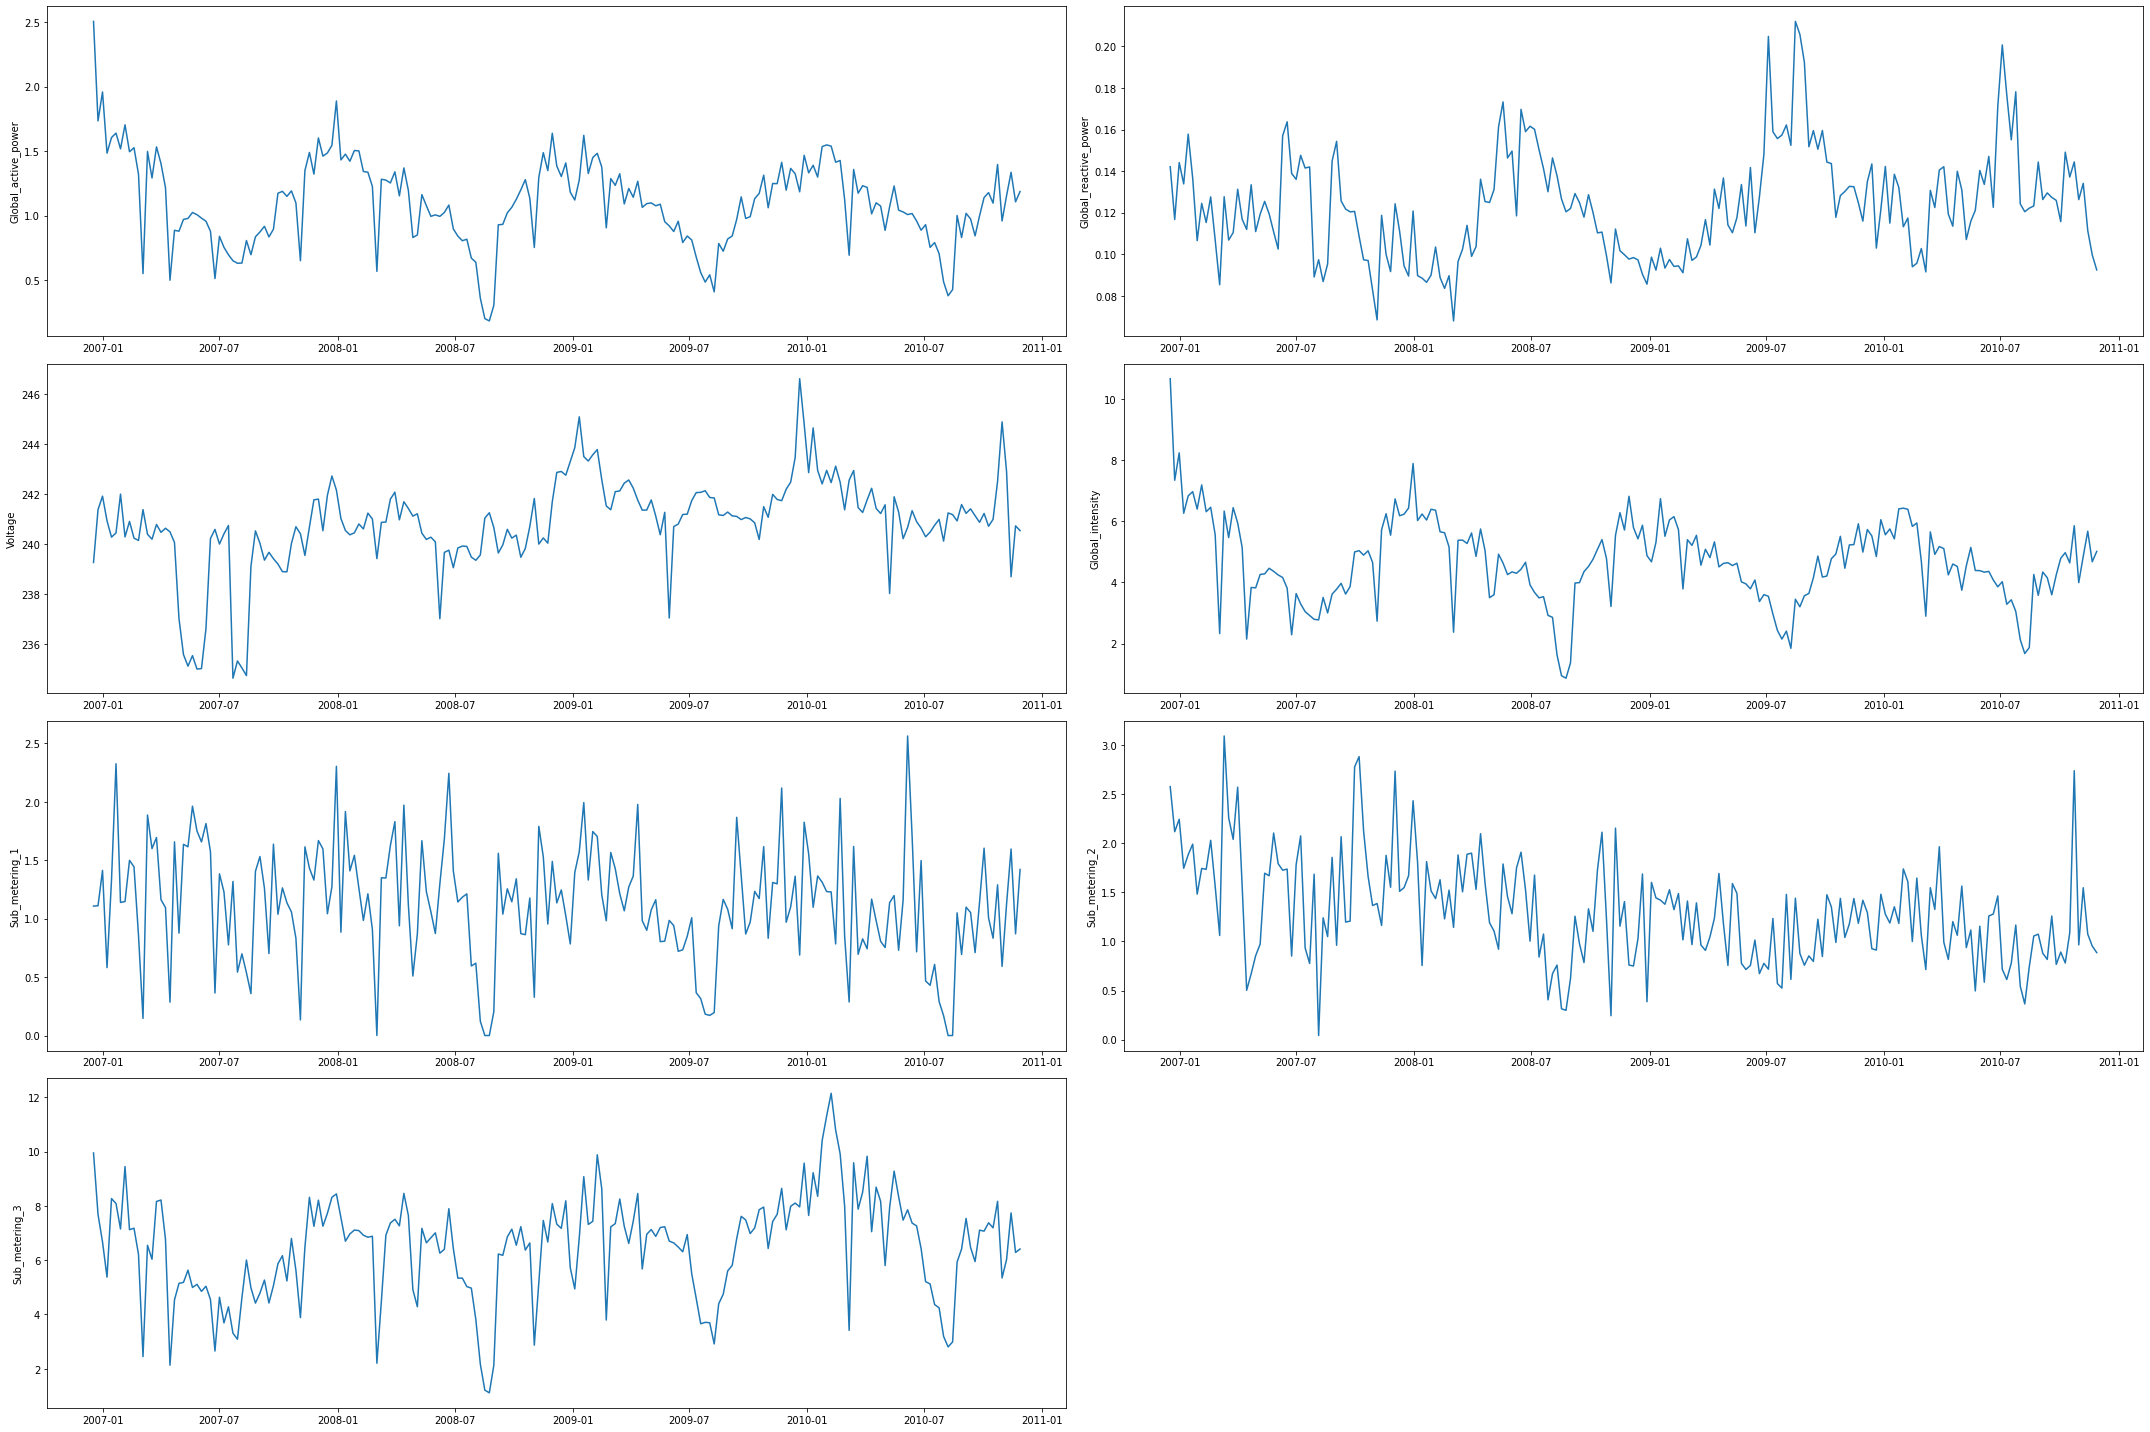

In [ ]:
plt.figure(figsize=(30,20))
plt_num=1
for i in list(df.columns):
  if plt_num<=6:
    plt.subplot(4,2,plt_num)
    plt.plot(df[i].resample('W').mean())
    plt.ylabel(i)
  else:
    plt.subplot(4,2,plt_num+0.5)
    plt.plot(df[i].resample('W').mean())
    plt.ylabel(i)
  plt_num=plt_num+1
plt.tight_layout()


From the heatmap below we dont find features with very high correlation. Also we can see as the data is resampled the correlation changes

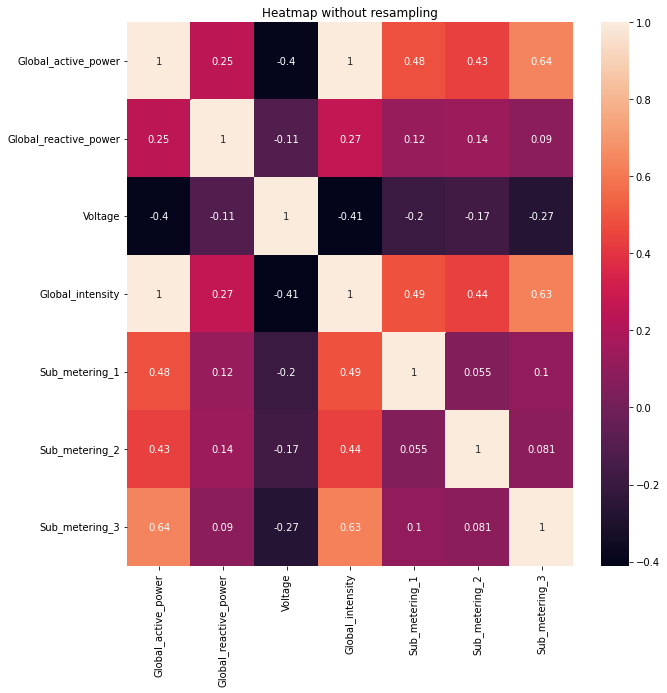

In [ ]:
plt.figure(figsize=(10,10))
import seaborn as sns
plt.title('Heatmap without resampling')
sns.heatmap(df.corr(),annot=True)

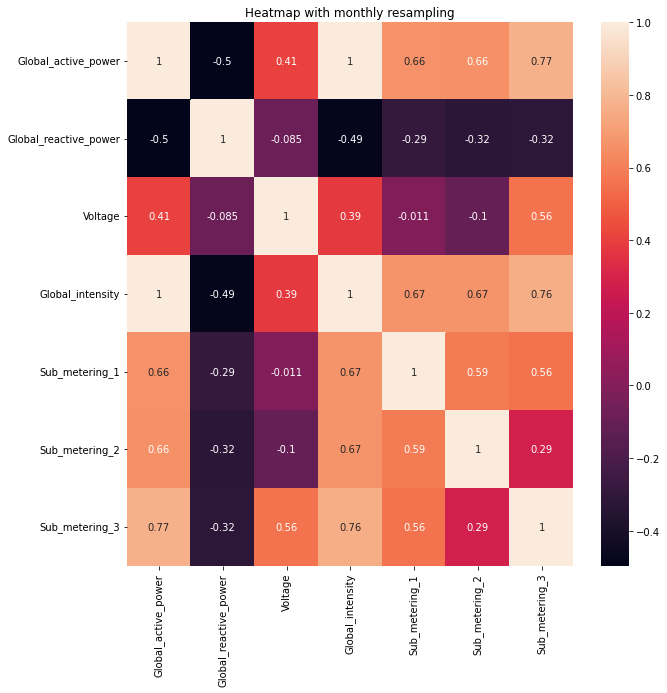

In [ ]:
plt.figure(figsize=(10,10))
import seaborn as sns
plt.title('Heatmap with monthly resampling')
sns.heatmap(df.resample('M').mean().corr(),annot=True)

## *UNIVARIATE ANALYSIS*

# *Time Series Forecasting for Global_Active_Power*

In [ ]:
#Resampling the Global active power monthly
sampled_data=pd.DataFrame(df['Global_active_power'].resample('M').mean())

PACF AND ACF PLOTS

<Figure size 2160x2160 with 0 Axes>

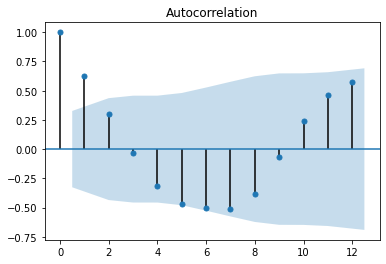

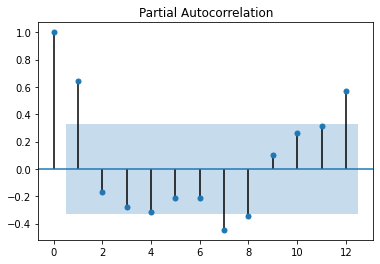

In [ ]:
plt.figure(figsize=(30,30))
split = int(0.75 * len(sampled_data))
sampled_train, sampled_test = sampled_data[:split], sampled_data[split:]

plot_acf(sampled_train.Global_active_power, lags=12)
plot_pacf(sampled_train.Global_active_power, lags=12)
plt.show()

AUGMENTED DICKEY FUELLER TEST TO CHECK FOR STATIONARITY

In [ ]:
print(adfuller(sampled_train.Global_active_power))

shifted_power = sampled_train.Global_active_power.diff(1)[1:]

print(adfuller(shifted_power))

(-5.557888304176707, 1.565797581828517e-06, 7, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, -15.262828893671518)
(-5.273937404480032, 6.199005990982984e-06, 10, 24, {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}, -10.849973263633764)


Since p-value is less than 0.05 the data is stationary.

In [ ]:
sampled_test.head()

,Global_active_power
dt,
2009-12-31,1.364408
2010-01-31,1.406754
2010-02-28,1.375841
2010-03-31,1.128329
2010-04-30,1.027297


Implementing ARIMA model with AR(1) and MA(1)

In [ ]:
model = ARIMA(sampled_train, order= (1,0,1))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting Time:", end - start)

Model fitting Time: 0.08677005767822266


In [ ]:
print(model_fit.summary())

                               ARMA Model Results                              
Dep. Variable:     Global_active_power   No. Observations:                   36
Model:                      ARMA(1, 1)   Log Likelihood                   3.160
Method:                        css-mle   S.D. of innovations              0.219
Date:                 Fri, 10 Jun 2022   AIC                              1.680
Time:                         23:09:55   BIC                              8.014
Sample:                     12-31-2006   HQIC                             3.891
                          - 11-30-2009                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.1604      0.126      9.241      0.000       0.914       1.407
ar.L1.Global_active_power     0.6615      0.172      3.837      0.001       0.

In [ ]:
pred_start_date = sampled_test.index[0]
pred_end_date = sampled_test.index[-1]

In [ ]:
predictions = model_fit.predict(start=str(pred_start_date), end=str(pred_end_date))


In [ ]:
preds=pd.DataFrame(predictions,columns=['Global_active_power'])

In [ ]:
sampled_test.loc[:,'Global_active_power_predicted']=preds['Global_active_power']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
sampled_test['Residuals']=sampled_test['Global_active_power']-sampled_test['Global_active_power_predicted']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


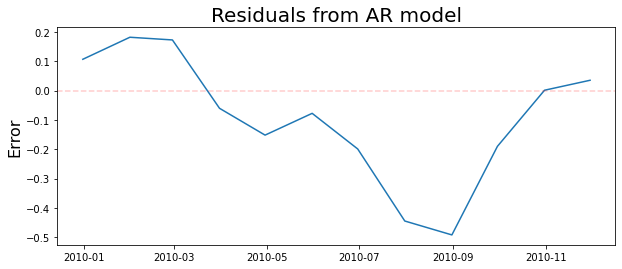

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sampled_test['Residuals'])
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color = 'r', linestyle='--',alpha=0.2)

From the graph below we can see our ARIMA model is not giving good results.

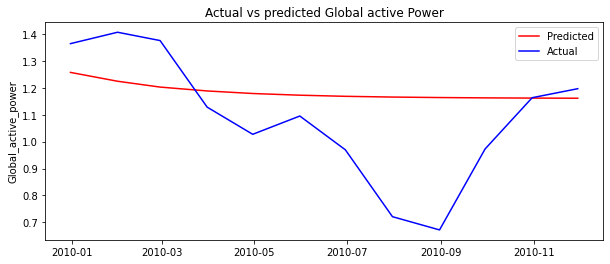

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sampled_test['Global_active_power_predicted'],color='r',label='Predicted')
plt.plot(sampled_test['Global_active_power'],color='b',label='Actual')
plt.title('Actual vs predicted Global active Power')
plt.ylabel('Global_active_power')
plt.legend(loc="upper right")

Implementing Rolling forecast Origin

In [ ]:
from datetime import timedelta
rolling_predictions = sampled_test.Global_active_power[:].copy()
temp = sampled_test.Global_active_power[:].copy()
data_1= sampled_data.Global_active_power[:].copy()
for train_end in temp.index:
  train_data = data_1[:train_end-timedelta(days=1)]
  model = ARIMA(train_data, order= (1,0,1))
  model_fit = model.fit()
  pred = model_fit.forecast()[0]
  rolling_predictions[train_end]=pred



In [ ]:
temp.head()

dt
2009-12-31    1.364408
2010-01-31    1.406754
2010-02-28    1.375841
2010-03-31    1.128329
2010-04-30    1.027297
Freq: M, Name: Global_active_power, dtype: float64

In [ ]:
rolling_predictions.head()

dt
2009-12-31    1.257432
2010-01-31    1.320154
2010-02-28    1.349568
2010-03-31    1.319234
2010-04-30    1.103845
Freq: M, Name: Global_active_power, dtype: float64

In [ ]:
rolling_residuals=temp-rolling_predictions

Text(0, 0.5, 'Error')

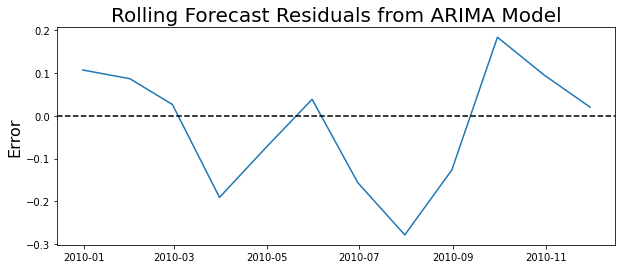

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
rolling_predictions=pd.DataFrame(rolling_predictions)

In [ ]:
rolling_predictions.head()

,Global_active_power
dt,
2009-12-31,1.257432
2010-01-31,1.320154
2010-02-28,1.349568
2010-03-31,1.319234
2010-04-30,1.103845


In [ ]:
sampled_test.head()

,Global_active_power,Global_active_power_predicted,Residuals
dt,,,
2009-12-31,1.364408,1.257432,0.106976
2010-01-31,1.406754,1.224596,0.182158
2010-02-28,1.375841,1.202873,0.172967
2010-03-31,1.128329,1.188503,-0.060174
2010-04-30,1.027297,1.178996,-0.151699


From the graph below we can see after implementing rolling forecast origin our ARIMA model is giving good results.

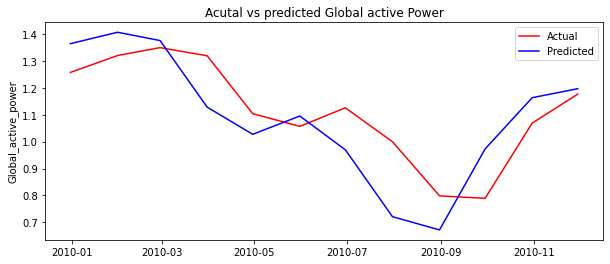

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions['Global_active_power'],color='r',label='Actual')
plt.plot(sampled_test['Global_active_power'],color='b',label='Predicted')
plt.title('Acutal vs predicted Global active Power')
plt.ylabel('Global_active_power')
plt.legend(loc="upper right")


# *Time Series Forecasting for Global_Reactive_Power*



In [ ]:
#Resampling the Global reactive power monthly
sampled_data=pd.DataFrame(df['Global_reactive_power'].resample('M').mean())

Text(0.5, 1.0, 'Global reactive power vs time')

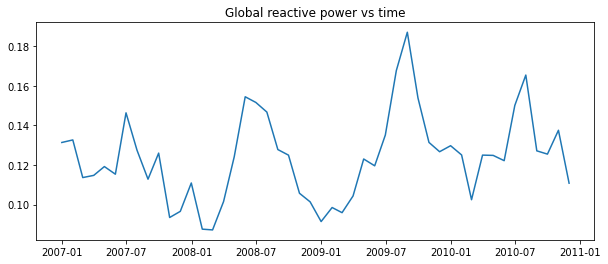

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sampled_data)
plt.title('Global reactive power vs time')

The plot shows us a bit of seasonality in the dataframe and it can be analysed more by looking into the decomposition of the series. Using statsmodel's seasonal_decompose, we can try to find trend, seasonal and residual(noise) components and analyze for more insight.

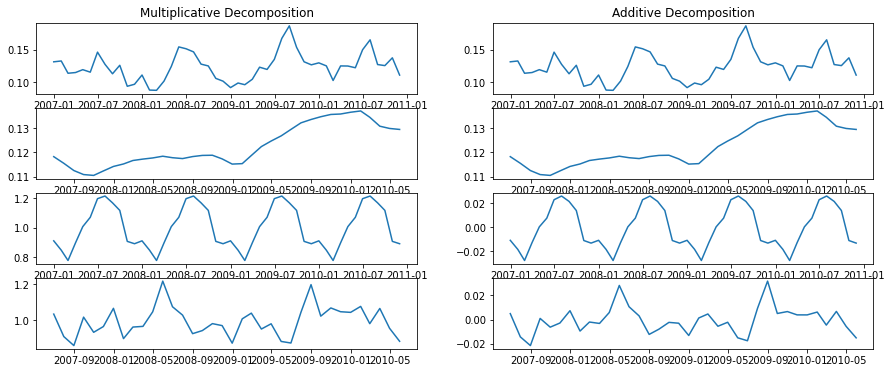

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 15, 6

fig, axes = pyplot.subplots(4, 2)

mul_decomposition = SDecompose(sampled_data.Global_reactive_power, model='multiplicative')
add_decomposition = SDecompose(sampled_data.Global_reactive_power, model='additive')

axes[0][0].plot(mul_decomposition.observed)
axes[0][0].set_title("Multiplicative Decomposition")
axes[1][0].plot(mul_decomposition.trend)
axes[2][0].plot(mul_decomposition.seasonal)
axes[3][0].plot(mul_decomposition.resid)

axes[0][1].plot(add_decomposition.observed)
axes[0][1].set_title("Additive Decomposition")
axes[1][1].plot(add_decomposition.trend)
axes[2][1].plot(add_decomposition.seasonal)
axes[3][1].plot(add_decomposition.resid)
pyplot.show()

PACF AND ACF PLOTS

<Figure size 2160x2160 with 0 Axes>

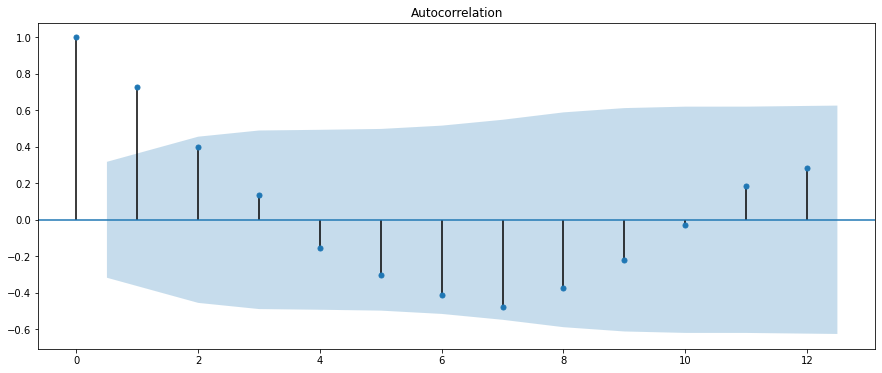

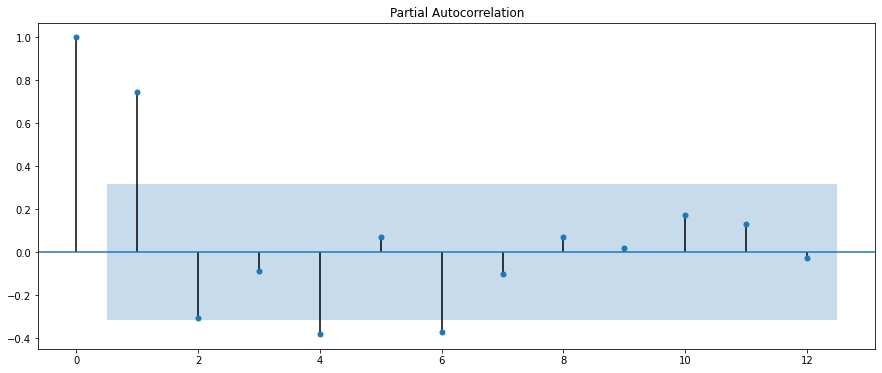

In [ ]:
plt.figure(figsize=(30,30))
split = int(0.8 * len(sampled_data))
sampled_train, sampled_test = sampled_data[:split], sampled_data[split:]

plot_acf(sampled_train.Global_reactive_power, lags=12)
plot_pacf(sampled_train.Global_reactive_power, lags=12)
plt.show()

AUGMENTED DICKEY FUELLER TEST TO CHECK FOR STATIONARITY

In [ ]:
print(adfuller(sampled_train.Global_reactive_power))

shifted_power = sampled_train.Global_reactive_power.diff(1)[1:]

print(adfuller(shifted_power))

(-2.8318962163258248, 0.053860082209357, 1, 36, {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, -149.71526141491088)
(-5.275873778612507, 6.142220106195449e-06, 0, 36, {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, -138.24360294267638)


P-value is less than 0.05 for difference of 1. Therefore we have to use I(1)

Implementing SARIMA model with AR(1) and MA(1)

In [ ]:
my_order = (1,1,1)
my_seasonal_order = (1, 0, 1, 12)
model = SARIMAX(sampled_train, order=my_order, seasonal_order=my_seasonal_order)
start = time()
model_fit = model.fit()
end = time()
print("Model fitting Time:", end - start)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:887: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model fitting Time: 0.586998701095581


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
pred_start_date = sampled_test.index[0]
pred_end_date = sampled_test.index[-1]

In [ ]:
predictions = model_fit.predict(start=str(pred_start_date), end=str(pred_end_date))

In [ ]:
preds=pd.DataFrame(predictions,columns=['Global_reactive_power'])

In [ ]:
sampled_test.loc[:,'Global_reactive_power_predicted']=preds['Global_reactive_power']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
sampled_test['Residuals']=sampled_test['Global_reactive_power']-sampled_test['Global_reactive_power_predicted']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


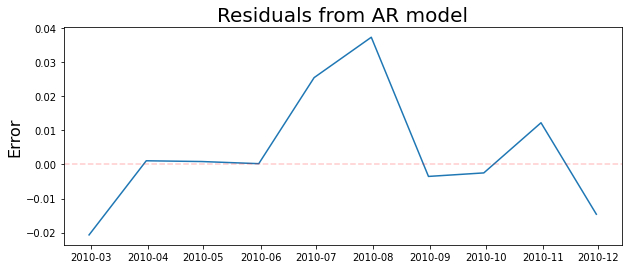

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sampled_test['Residuals'])
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color = 'r', linestyle='--',alpha=0.2)

From the graph below, we can observe SARIMA model does not give us good results.

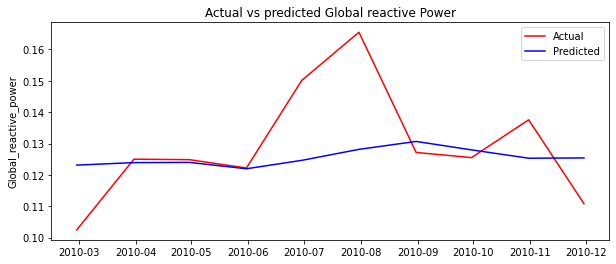

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sampled_test['Global_reactive_power'],color='r',label='Actual')
plt.plot(sampled_test['Global_reactive_power_predicted'],color='b',label='Predicted')
plt.title('Actual vs predicted Global reactive Power')
plt.ylabel('Global_reactive_power')
plt.legend(loc="upper right")

Implementing Rolling forecast origin

In [ ]:
from datetime import timedelta
rolling_predictions = sampled_test.Global_reactive_power[:].copy()
temp = sampled_test.Global_reactive_power[:].copy()
data_1= sampled_data.Global_reactive_power[:].copy()
for train_end in temp.index:
  train_data = data_1[:train_end-timedelta(days=1)]
  model = SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,12))
  model_fit = model.fit()
  pred = model_fit.forecast()[0]
  rolling_predictions[train_end]=pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting aut

In [ ]:
rolling_residuals=temp-rolling_predictions

Text(0, 0.5, 'Error')

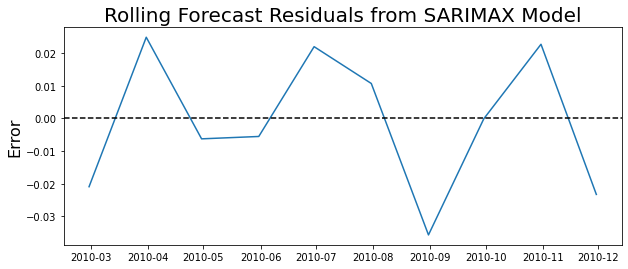

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMAX Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
rolling_predictions=pd.DataFrame(rolling_predictions)

From the plot below we can see after implemeting rolling forecast origin on SARIMA model we are getting good results.

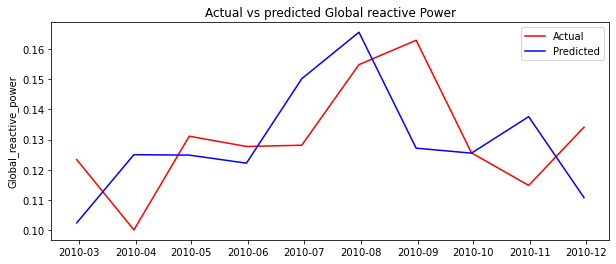

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions['Global_reactive_power'],color='r',label='Actual')
plt.plot(sampled_test['Global_reactive_power'],color='b',label='Predicted')
plt.title('Actual vs predicted Global reactive Power')
plt.ylabel('Global_reactive_power')
plt.legend(loc="upper right")

## *MULTIVARIATE ANALYSIS USING LSTM*

A function to convert the time series data into a supervised machine learning problem is written below

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
df_resampled = df.resample('M').mean() 
df_resampled.shape

(48, 7)

In [ ]:
values=df_resampled.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)
modified_data = series_to_supervised(scaled_data, 1, 1)

In [ ]:
modified_data.drop(modified_data.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
modified_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,1.000000,0.442324,0.703360,1.000000,0.721703,0.928558,0.667469,0.781405
2,0.781405,0.455242,0.643171,0.780876,0.731404,0.691058,0.664375,0.692187
3,0.692187,0.264796,0.599854,0.687415,0.679214,0.597141,0.583706,0.641439
4,0.641439,0.275897,0.599188,0.636932,0.791727,1.000000,0.560102,0.388975
5,0.388975,0.320475,0.488072,0.388890,0.611194,0.271847,0.374806,0.436616


Split the data into train and test and transformed the data into 3D format for input into LSTM neural network.

In [ ]:

values = modified_data.values
n_train_time = 36
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(36, 1, 7) (36,) (11, 1, 7) (11,)


Model architecture

1) LSTM with 100 neurons in the first visible layer

3) dropout 20%

4) 1 neuron in the output layer for predicting Global_active_power.

5) The input shape will be 1 time step with 7 features.

6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

7) The model will be fit for 50 training epochs with a batch size of 70.

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

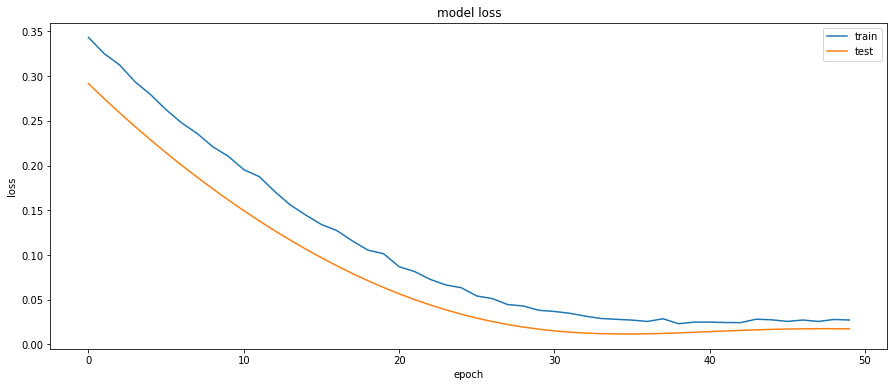

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.214


From the plot below we can see that the resuts of LSTM are not good. It can be improved by changing the model architecture

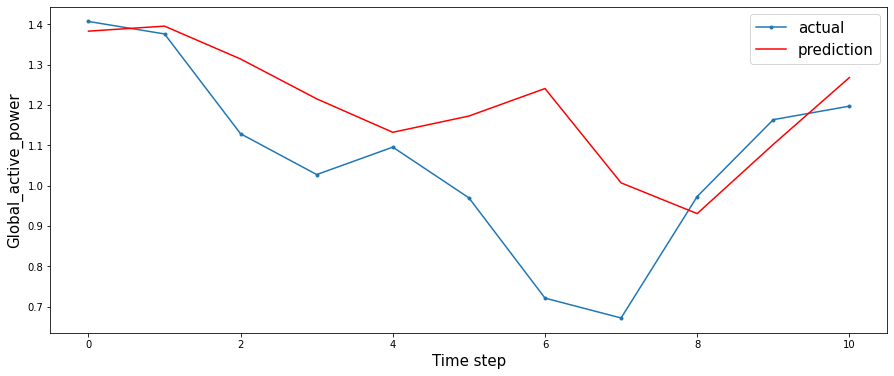

In [ ]:
aa=[x for x in range(11)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()